In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.cluster as cluster
import sklearn.metrics as skmet

In [3]:
from sklearn.cluster import KMeans
co2emi = pd.read_csv("co2kgpcapta.csv", encoding='windows-1254')

In [4]:
co2emi = co2emi[(co2emi["1990 [YR1990]"].notna()) & (co2emi["2020 [YR2020]"].notna())]

co2emi = co2emi.reset_index(drop=True)

In [5]:
co2emi["1990 [YR1990]"] = pd.to_numeric(co2emi["1990 [YR1990]"], errors='coerce')
co2emi["2020 [YR2020]"] = pd.to_numeric(co2emi["2020 [YR2020]"], errors='coerce')

In [6]:
#print(co2emi.describe())
# print(gdp_head)

# extract 1990
growth = co2emi[["Country Name", "1990 [YR1990]"]].copy()

# and calculate the growth over 30 years
growth["Growth"] = 100.0/30.0 * (co2emi["2020 [YR2020]"]-co2emi["1990 [YR1990]"]) / co2emi["1990 [YR1990]"] 
print(growth.describe())
print()
print(growth.dtypes)

       1990 [YR1990]      Growth
count     238.000000  238.000000
mean        4.178043         inf
std         5.305961         NaN
min         0.000000   -2.525025
25%         0.472474   -0.814518
50%         1.955873    0.391189
75%         6.676542    2.994352
max        29.553490         inf

Country Name      object
1990 [YR1990]    float64
Growth           float64
dtype: object


In [7]:
growth = growth.dropna()
growth = growth[ ~( growth.isin( [np.inf, -np.inf]).any(axis =1) )]

In [8]:
print(growth.describe())

       1990 [YR1990]      Growth
count     233.000000  233.000000
mean        4.267701    2.254533
std         5.326884    7.625775
min         0.034210   -2.525025
25%         0.496616   -0.827533
50%         2.033681    0.360119
75%         6.750912    2.663665
max        29.553490   70.129598


In [9]:
growth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233 entries, 0 to 265
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country Name   233 non-null    object 
 1   1990 [YR1990]  233 non-null    float64
 2   Growth         233 non-null    float64
dtypes: float64(2), object(1)
memory usage: 7.3+ KB


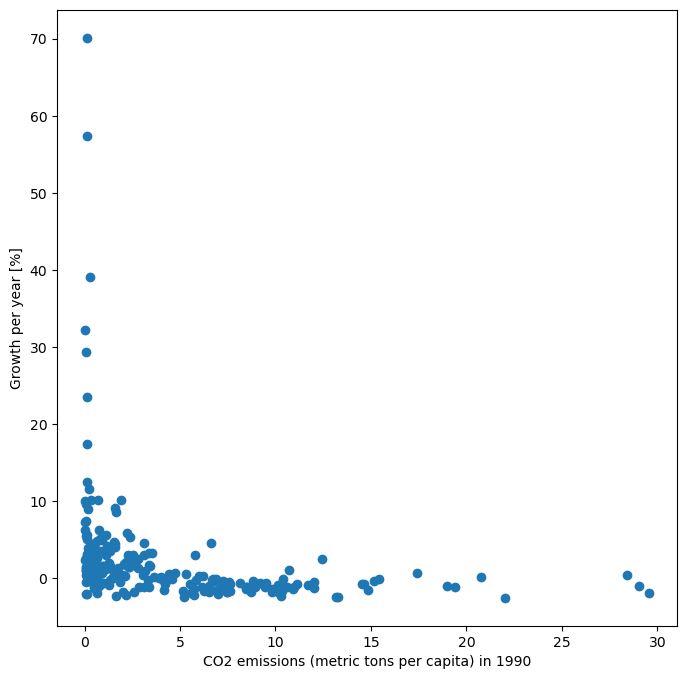

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(growth["1990 [YR1990]"], growth["Growth"])

plt.xlabel("CO2 emissions (metric tons per capita) in 1990")
plt.ylabel("Growth per year [%]")
plt.show()

       1990 [YR1990]      Growth
count     233.000000  233.000000
mean        4.267701    2.254533
std         5.326884    7.625775
min         0.034210   -2.525025
25%         0.496616   -0.827533
50%         2.033681    0.360119
75%         6.750912    2.663665
max        29.553490   70.129598


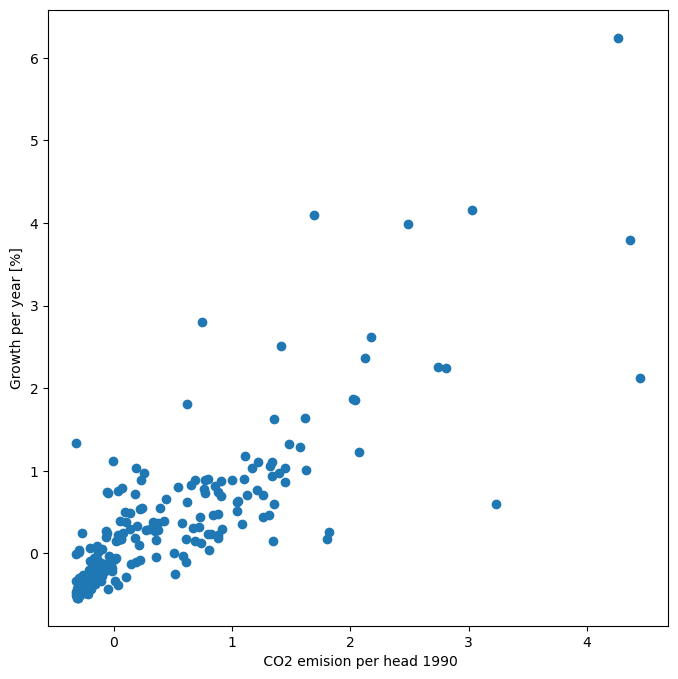

In [11]:
import sklearn.preprocessing as pp
from scipy.stats import mstats
# create a scaler object
scaler = pp.RobustScaler()

# and set up the scaler
# extract the columns for clustering

#print("NaN values:", np.any(np.isnan(co2emi)))

dt_ex = co2emi[["1990 [YR1990]", "2020 [YR2020]"]]
print(growth.describe())
scaler.fit(dt_ex)

# apply the scaling
norm = scaler.transform(dt_ex)

plt.figure(figsize=(8, 8))
plt.scatter(norm[:, 0], norm[:, 1])

plt.xlabel(" CO2 emision per head 1990")
plt.ylabel("Growth per year [%]")
plt.show()


In [12]:
def one_silhoutte(xy, n):
    """ Calculates silhoutte score for n clusters """
    xy_no_nan = np.nan_to_num(xy, nan=0)
    # set up the clusterer with the number of expected clusters
    kmeans = cluster.KMeans(n_clusters=n, n_init=20)

    # Fit the data, results are stored in the kmeans object
    kmeans.fit(xy_no_nan)     # fit done on x,y pairs

    labels = kmeans.labels_
    
    # calculate the silhoutte score
    score = (skmet.silhouette_score(xy_no_nan, labels))

    return score


# calculate silhouette score for 2 to 10 clusters
for ic in range(2, 11):
    score = one_silhoutte(norm, ic)
    print(f"The silhouette score for {ic: 3d} is {score: 7.4f}")   # allow for minus signs

The silhouette score for   2 is  0.6329
The silhouette score for   3 is  0.5953
The silhouette score for   4 is  0.5562
The silhouette score for   5 is  0.5090
The silhouette score for   6 is  0.4899
The silhouette score for   7 is  0.4914
The silhouette score for   8 is  0.4915
The silhouette score for   9 is  0.5027
The silhouette score for  10 is  0.5061


C:\Users\admin\AppData\Local\Temp\ipykernel_14068\1646309197.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


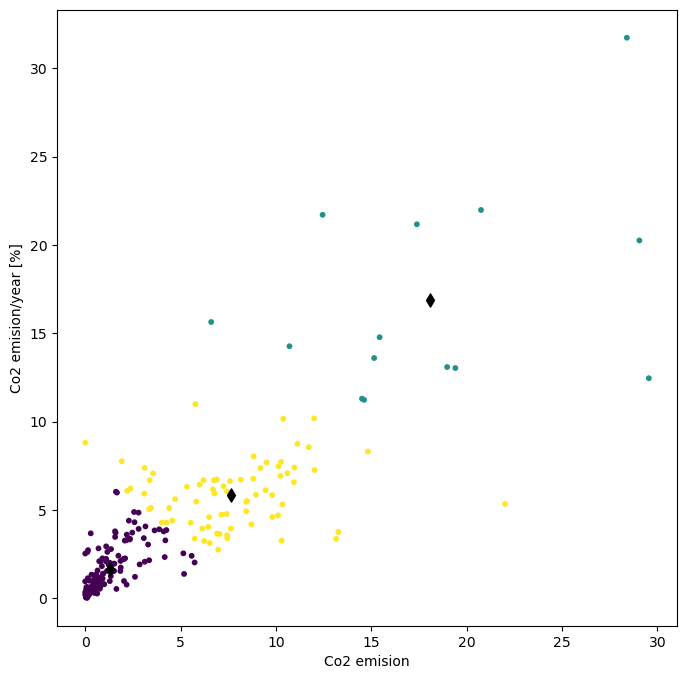

In [15]:
import matplotlib.cm as cm
norm_no_nan = np.nan_to_num(norm, nan=0)
# set up the clusterer with the number of expected clusters
kmeans = cluster.KMeans(n_clusters=3, n_init=20)

# Fit the data, results are stored in the kmeans object
kmeans.fit(norm_no_nan)     # fit done on x,y pairs

# extract cluster labels
labels = kmeans.labels_

# extract the estimated cluster centres and convert to original scales
cen = kmeans.cluster_centers_
cen = scaler.inverse_transform(cen)
xkmeans = cen[:, 0]
ykmeans = cen[:, 1]    

# print(df_norm)
# print(labels)
#print(norm)

plt.figure(figsize=(8.0, 8.0))
cmap = cm.get_cmap('viridis')
# plot data with kmeans cluster number
plt.scatter(co2emi["1990 [YR1990]"], co2emi["2020 [YR2020]"], 10, labels, marker="o", cmap=cmap)
    
# show cluster centres
plt.scatter(xkmeans, ykmeans, 45, "k", marker="d")
    
plt.xlabel("Co2 emision")
plt.ylabel("Co2 emision/year [%]")

plt.show()
                      